In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler


In [27]:
train_df=pd.read_csv(r'C:\Users\EDWIN\OneDrive\Documents\GitHub\Engineers_Salary_Prediction\engineers_salary_prediction\train.csv')
train_df.head()

,obs,job_title,job_posted_date,salary_category,job_state,feature_1,feature_2,feature_3,feature_4,feature_5,...,job_desc_291,job_desc_292,job_desc_293,job_desc_294,job_desc_295,job_desc_296,job_desc_297,job_desc_298,job_desc_299,job_desc_300
0,1,Others,2024/07,High,NY,A,0.6429,False,False,True,...,-0.362079,-0.499308,-0.367894,-0.214881,0.014870,-0.271177,-0.113347,-0.587955,-0.919095,-0.207340
1,2,Job_Title_1,2024/07,Low,CA,A,0.4678,False,False,False,...,-0.300989,-0.415411,-0.341824,-0.319064,0.042322,-0.124755,0.023489,-0.893224,-0.823024,0.112364
2,3,Others,2024/07,Low,CA,A,0.4610,False,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,4,Others,2024/07,Low,CA,A,0.5064,False,False,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5,Others,2024/07,Low,CA,A,0.4640,False,False,False,...,-0.406159,-0.654657,-0.074398,-0.464479,0.081037,-0.136992,-0.276270,-0.696853,-0.601466,0.089939


In [28]:
train_df.isnull().sum()

obs                 0
job_title           0
job_posted_date     1
salary_category     0
job_state          27
                   ..
job_desc_296        0
job_desc_297        0
job_desc_298        0
job_desc_299        0
job_desc_300        0
Length: 317, dtype: int64

In [29]:
from sklearn.impute import SimpleImputer

def preprocessing(df):
    # Impute missing values for numerical columns with the mean
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    num_imputer = SimpleImputer(strategy='mean')
    df[numerical_columns] = num_imputer.fit_transform(df[numerical_columns])

    # Impute missing values for categorical columns with the mode
    categorical_columns = df.select_dtypes(include=['object']).columns
    cat_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_columns] = cat_imputer.fit_transform(df[categorical_columns])

    # Encode categorical columns
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Normalize numerical features
    obs = df['obs'].astype(int)
    scaler = StandardScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    # Separate target variable and drop irrelevant columns
    
    irrelevant_columns = ['obs', 'job_posted_date'] if 'obs' in df.columns else ['job_posted_date']
    df = df.drop(columns=irrelevant_columns, errors='ignore')

    return df, obs

In [30]:
train_df,obs=preprocessing(train_df)

In [31]:
train_df.head()

,job_title,salary_category,job_state,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,job_desc_291,job_desc_292,job_desc_293,job_desc_294,job_desc_295,job_desc_296,job_desc_297,job_desc_298,job_desc_299,job_desc_300
0,27,0,24,0,0.464773,False,False,True,True,True,...,-0.575847,0.016726,-0.125470,-0.038659,-0.334028,0.095104,0.074235,0.076596,-0.663640,-0.949340
1,0,1,4,0,-1.147179,False,False,False,True,True,...,-0.310235,0.298495,-0.018553,-0.465938,-0.141471,0.847757,0.928632,-1.013079,-0.375325,1.192069
2,27,1,4,0,-1.209779,False,False,False,True,True,...,0.998435,1.693653,1.383303,0.842610,-0.438333,1.489031,0.781969,2.175330,2.094609,0.439445
3,27,1,4,0,-0.791831,False,False,False,True,True,...,0.998435,1.693653,1.383303,0.842610,-0.438333,1.489031,0.781969,2.175330,2.094609,0.439445
4,27,1,4,0,-1.182161,False,False,False,True,True,...,-0.767502,-0.505014,1.078187,-1.062312,0.130086,0.784854,-0.943056,-0.312121,0.289581,1.041865


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


X=train_df.drop(columns=['salary_category'], errors='ignore')
y=train_df['salary_category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rfc = RandomForestClassifier(random_state=42)
search = RandomizedSearchCV(rfc, param_distributions=param_dist, n_iter=20, cv=3, n_jobs=-1, verbose=1)
search.fit(X_train, y_train)
best_model = search.best_estimator_

importances = best_model.feature_importances_
feature_names = X.columns
important_features = feature_names[np.argsort(importances)[-20:]]  # Top 20

X_train_imp = X_train[important_features]
X_test_imp = X_test[important_features]
best_model.fit(X_train_imp, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_leaf=2,
                       n_estimators=200, random_state=42)

Accuracy: 0.74609375
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75        94
           1       0.89      0.76      0.82        85
           2       0.67      0.65      0.66        77

    accuracy                           0.75       256
   macro avg       0.75      0.74      0.74       256
weighted avg       0.75      0.75      0.75       256



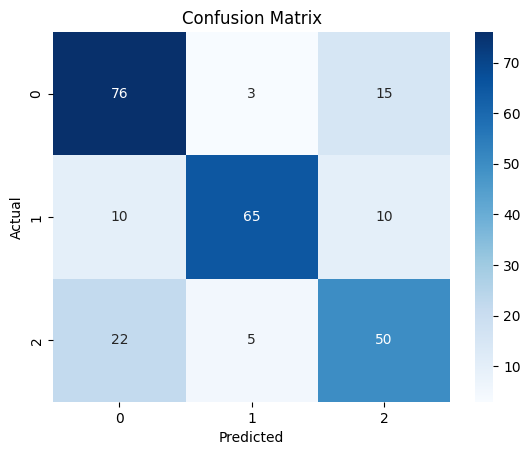

In [33]:
y_pred = best_model.predict(X_test_imp)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [49]:
from xgboost import XGBClassifier
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')


ModuleNotFoundError: No module named 'xgboost'

In [34]:
test_df=pd.read_csv(r'C:\Users\EDWIN\OneDrive\Documents\GitHub\Engineers_Salary_Prediction\engineers_salary_prediction\test.csv')
test_df.head()

,obs,job_title,job_posted_date,job_state,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,job_desc_291,job_desc_292,job_desc_293,job_desc_294,job_desc_295,job_desc_296,job_desc_297,job_desc_298,job_desc_299,job_desc_300
0,1281,Others,2024/06,CA,A,0.6473,False,False,True,True,...,-0.054078,-0.573635,-0.306883,-0.325092,0.089463,-0.353476,-0.159314,-0.667958,-0.702116,-0.206267
1,1282,Others,2024/08,NY,A,0.4238,True,False,False,False,...,-0.868718,-0.337967,-0.179036,-0.717763,0.404843,0.032468,-0.190448,-1.261702,-0.505897,0.082080
2,1283,Others,2023/01,CA,A,0.6219,True,False,False,True,...,-0.416109,-0.619822,-0.493653,-0.347556,0.071679,-0.331212,-0.381348,-0.506540,-0.773561,-0.105221
3,1284,Job_Title_5,2024/06,NY,A,0.6704,False,False,False,True,...,-0.297560,-0.481448,-0.497642,-0.254823,0.047404,-0.362739,-0.102704,-0.491272,-0.808156,-0.048326
4,1285,Others,2024/05,CA,A,0.7310,False,False,False,True,...,-0.176458,-0.726473,-0.323976,-0.145825,-0.046866,-0.229873,-0.568318,-0.614605,-0.770506,0.142140


In [35]:
obs=test_df['obs']
len(obs)

854

In [36]:
test_df,obs=preprocessing(test_df)
test_df.head()

,job_title,job_state,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,job_desc_291,job_desc_292,job_desc_293,job_desc_294,job_desc_295,job_desc_296,job_desc_297,job_desc_298,job_desc_299,job_desc_300
0,27,3,0,0.542602,False,False,True,True,False,False,...,0.756974,-0.232551,0.173768,-0.472765,0.235840,-0.258799,-0.211650,-0.195685,0.011406,-1.055532
1,27,22,0,-1.550332,True,False,False,False,False,False,...,-2.761949,0.561617,0.679367,-2.108373,2.594787,1.635352,-0.404345,-2.311123,0.613724,1.039747
2,27,3,0,0.304747,True,False,False,True,True,False,...,-0.806854,-0.388198,-0.564849,-0.566336,0.102815,-0.149529,-1.585891,0.379428,-0.207905,-0.321281
3,22,22,0,0.758919,False,False,False,True,False,False,...,-0.294771,0.078107,-0.580621,-0.180071,-0.078753,-0.304259,0.138728,0.433828,-0.314099,0.092153
4,27,3,0,1.326399,False,False,False,True,True,False,...,0.228339,-0.747597,0.106170,0.273943,-0.783861,0.347824,-2.743109,-0.005595,-0.198527,1.476173


In [45]:
X_test_imp = test_df[important_features]
print(len(X_test_imp))
y_pred = best_model.predict(X_test_imp)

854


In [46]:
label_map = {0: 'High', 1: 'Low', 2: 'Medium'}
predictions = [label_map[p] for p in y_pred]
predictions


['High',
 'High',
 'High',
 'Low',
 'High',
 'Medium',
 'High',
 'Low',
 'Medium',
 'Medium',
 'Medium',
 'High',
 'Low',
 'Low',
 'Low',
 'High',
 'High',
 'High',
 'Medium',
 'High',
 'High',
 'Medium',
 'High',
 'Low',
 'High',
 'High',
 'Low',
 'Low',
 'High',
 'High',
 'Low',
 'Low',
 'Medium',
 'High',
 'Medium',
 'Low',
 'Medium',
 'Low',
 'Medium',
 'Medium',
 'Low',
 'High',
 'Medium',
 'High',
 'Low',
 'Medium',
 'High',
 'Low',
 'Low',
 'Low',
 'Medium',
 'High',
 'Low',
 'High',
 'Low',
 'High',
 'High',
 'Medium',
 'Medium',
 'Medium',
 'High',
 'Medium',
 'High',
 'Medium',
 'Medium',
 'High',
 'High',
 'High',
 'High',
 'Medium',
 'Medium',
 'Low',
 'Low',
 'Medium',
 'Medium',
 'Low',
 'Low',
 'High',
 'High',
 'Medium',
 'High',
 'High',
 'High',
 'Low',
 'Medium',
 'Medium',
 'Low',
 'Low',
 'Medium',
 'High',
 'Low',
 'Medium',
 'High',
 'Low',
 'Medium',
 'High',
 'Medium',
 'High',
 'Medium',
 'Low',
 'High',
 'High',
 'Medium',
 'High',
 'Low',
 'Low',
 'Medium',


In [47]:
submission = pd.DataFrame({
    'obs': obs,
    'salary_category': predictions
})

submission.to_csv('submission.csv', index=False)
